## BA820 Project Proposal B1 Team 4 – Childcare Cost

This notebook conducts preliminary exploratory data analysis (EDA) on the National Database of Childcare Prices dataset at the county level. The goal is to uncover meaningful structural patterns related to childcare cost, affordability, family work structures, and labor market composition, and to develop insight-driven domain questions suitable for unsupervised analysis. The analysis emphasizes understanding variability, outliers, and hidden structure in the data rather than early model selection.

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = "/content/drive/My Drive/BA820/"

childcare = pd.read_csv(file_path + "childcare_costs.csv")
counties = pd.read_csv(file_path + "counties.csv")

childcare.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,...,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
0,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,...,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40
1,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,...,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68
2,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,...,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96
3,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,...,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25
4,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,...,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53


In [ ]:
counties.head()


,county_fips_code,county_name,state_name,state_abbreviation
0,1001,Autauga County,Alabama,AL
1,1003,Baldwin County,Alabama,AL
2,1005,Barbour County,Alabama,AL
3,1007,Bibb County,Alabama,AL
4,1009,Blount County,Alabama,AL


In [ ]:
childcare = pd.read_csv(file_path + "childcare_costs.csv")
counties = pd.read_csv(file_path + "counties.csv")

print(childcare.shape)
print(counties.shape)


(34567, 61)
(3144, 4)


## Dataset Overview

The Childcare Costs dataset contains county-level information from the National Database of Childcare Prices, including weekly childcare prices by provider type and child age group, along with socioeconomic indicators such as income, poverty, labor force participation, occupation mix, household work structures, and demographic composition from 2008 to 2018. This dataset is well suited for exploratory and unsupervised analysis because it captures multiple interacting dimensions of cost, affordability, family structure, and labor markets, enabling segmentation of counties into meaningful profiles and identification of outliers where childcare is particularly financially burdensome.

In [ ]:
#Joining County names
df = childcare.merge(counties, on="county_fips_code", how="left")

print(df.shape)
df[["county_fips_code", "county_name", "state_abbreviation", "study_year"]].head()

(34567, 64)


,county_fips_code,county_name,state_abbreviation,study_year
0,1001,Autauga County,AL,2008
1,1001,Autauga County,AL,2009
2,1001,Autauga County,AL,2010
3,1001,Autauga County,AL,2011
4,1001,Autauga County,AL,2012


## Minimal Data Preparation

Only minimal preparation is performed to preserve the dataset’s original structure for EDA. We verify missingness, confirm types, and create a small number of derived variables to support interpretation (without filtering or removing outliers).

In [ ]:
#checking missing values
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(20)


,0
mfccsa,0.323546
mfcc_preschool,0.323546
mfcc_infant,0.323546
mfcc_toddler,0.323546
mc_preschool,0.317470
mcsa,0.317470
mc_infant,0.317470
mc_toddler,0.317470
h_6to17_single_m,0.000058
h_under6_single_m,0.000058


In [ ]:
price_cols = ["mc_infant","mc_toddler","mc_preschool","mfcc_infant","mfcc_toddler","mfcc_preschool","mcsa","mfccsa"]
missing_rate[price_cols].sort_values(ascending=False)

,0
mfcc_infant,0.323546
mfccsa,0.323546
mfcc_preschool,0.323546
mfcc_toddler,0.323546
mc_preschool,0.317470
mc_toddler,0.317470
mc_infant,0.317470
mcsa,0.317470


# EDA Insight 1: Cost Measurement and Childcare Burden

In [ ]:
#defining filtered frames
#center based price price columns
core_price_cols = ["mc_infant", "mc_toddler", "mc_preschool"]

#All price columns
all_price_cols = ["mc_infant","mc_toddler","mc_preschool","mfcc_infant","mfcc_toddler","mfcc_preschool","mcsa","mfccsa"]
#keeping the columns where core childcare prices are present
df_prices = df.dropna(subset=core_price_cols).copy()

print("Original rows:", df.shape[0])
print("Rows with core center-based prices:", df_prices.shape[0])

Original rows: 34567
Rows with core center-based prices: 23593


In [ ]:
#burden calculation in terms of price relative to income
df_burden = df.dropna(subset=["mc_infant", "mhi_2018"]).copy()
print("Rows with mc_infant + mhi_2018:", df_burden.shape[0])

Rows with mc_infant + mhi_2018: 23593


**Interpretation**

We first evaluated the extent of missing data in the childcare price variables and discovered approximately 32% systematic missingness, especially concerning family childcare prices. Our focus is primarily on the center-based price columns, as they provide a more reliable foundation for cost analysis.

Additionally, we are developing a feature called "burden," which calculates the cost of childcare in relation to income.

# EDA Insight 2: Childcare Prices Alone Do Not Explain Mothers’ Workforce Participation


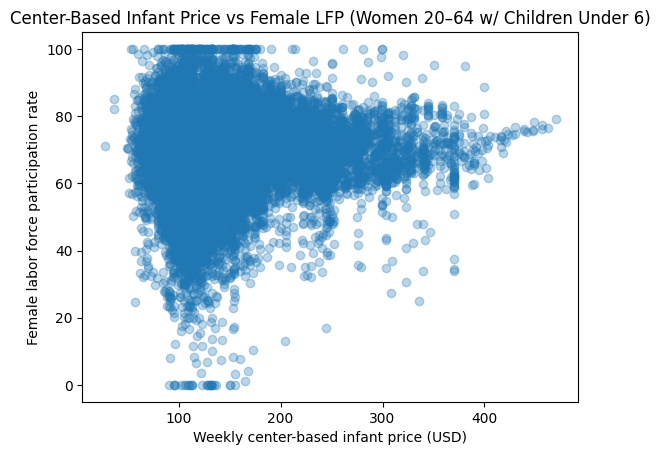

In [ ]:
x = df_prices["mc_infant"]
y = df_prices["flfpr_20to64_under6"]

mask = x.notna() & y.notna()

plt.figure()
plt.scatter(x[mask], y[mask], alpha=0.3)
plt.title("Center-Based Infant Price vs Female LFP (Women 20–64 w/ Children Under 6)")
plt.xlabel("Weekly center-based infant price (USD)")
plt.ylabel("Female labor force participation rate")
plt.show()


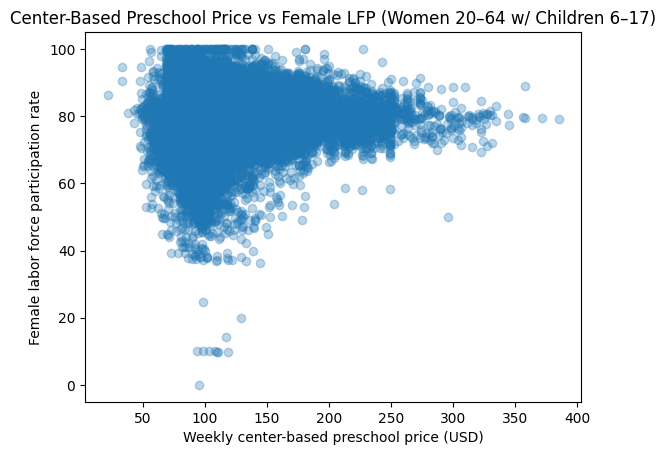

In [ ]:
# Same for women with children 6–17
x = df_prices["mc_preschool"]
y = df_prices["flfpr_20to64_6to17"]

mask = x.notna() & y.notna()

plt.figure()
plt.scatter(x[mask], y[mask], alpha=0.3)
plt.title("Center-Based Preschool Price vs Female LFP (Women 20–64 w/ Children 6–17)")
plt.xlabel("Weekly center-based preschool price (USD)")
plt.ylabel("Female labor force participation rate")
plt.show()

In [ ]:
# Correlation on the rows where core prices exist
eda_cols = [
    "mc_infant", "mc_toddler", "mc_preschool",
    "mfcc_infant", "mfcc_toddler", "mfcc_preschool",
    "flfpr_20to64", "flfpr_20to64_under6", "flfpr_20to64_6to17",
    "mlfpr_20to64", "mhi_2018", "pr_f", "pr_p"
]

corr = df_prices[eda_cols].corr(numeric_only=True)
corr.round(2)


,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool,flfpr_20to64,flfpr_20to64_under6,flfpr_20to64_6to17,mlfpr_20to64,mhi_2018,pr_f,pr_p
mc_infant,1.00,0.96,0.96,0.91,0.90,0.90,0.30,0.10,0.12,0.22,0.60,-0.37,-0.35
mc_toddler,0.96,1.00,0.98,0.89,0.91,0.89,0.34,0.13,0.15,0.24,0.60,-0.39,-0.37
mc_preschool,0.96,0.98,1.00,0.90,0.90,0.90,0.33,0.12,0.13,0.24,0.62,-0.39,-0.37
mfcc_infant,0.91,0.89,0.90,1.00,0.97,0.96,0.28,0.08,0.11,0.21,0.60,-0.37,-0.35
mfcc_toddler,0.90,0.91,0.90,0.97,1.00,0.99,0.29,0.09,0.12,0.21,0.59,-0.37,-0.36
mfcc_preschool,0.90,0.89,0.90,0.96,0.99,1.00,0.29,0.09,0.12,0.22,0.60,-0.37,-0.36
flfpr_20to64,0.30,0.34,0.33,0.28,0.29,0.29,1.00,0.56,0.66,0.56,0.53,-0.62,-0.61
flfpr_20to64_under6,0.10,0.13,0.12,0.08,0.09,0.09,0.56,1.00,0.38,0.18,0.15,-0.26,-0.24
flfpr_20to64_6to17,0.12,0.15,0.13,0.11,0.12,0.12,0.66,0.38,1.00,0.33,0.28,-0.42,-0.40
mlfpr_20to64,0.22,0.24,0.24,0.21,0.21,0.22,0.56,0.18,0.33,1.00,0.52,-0.54,-0.56


**Interpretation**

We examined scatter-plots for center-based infant prices and female labor force participation for mothers with children under 6 and for childeren between 6-17 and found out that for counties with low childcare prices, maternal workforce participation varies dramatically, while high-price counties tend to cluster around higher participation rates. This shows that in the counties where there is higher childcare costs, there is higher female labor participation.

We also found out that childcare price measures are strongly correlated with each other, meaning counties tend to be consistently high-cost or low-cost across ages. At the same time, childcare prices are strongly tied to county income and negatively related to poverty, which suggests that high prices often show up in higher-income counties

# EDA Insight 3: Household structure varies a lot across counties


In [ ]:
under6_cols = ["h_under6_both_work", "h_under6_f_work", "h_under6_m_work", "h_under6_single_m"]
six17_cols  = ["h_6to17_both_work", "h_6to17_fwork", "h_6to17_mwork", "h_6to17_single_m"]

df_hh = df[["county_fips_code","study_year","households"] + under6_cols + six17_cols].copy()
for c in under6_cols + six17_cols:
    df_hh[c + "_share"] = df_hh[c] / df_hh["households"]
df_hh[[c + "_share" for c in under6_cols]].describe().T

,count,mean,std,min,25%,50%,75%,max
h_under6_both_work_share,34567.0,0.069792,0.025683,0.0,0.053077,0.067550,0.084243,0.355140
h_under6_f_work_share,34567.0,0.043318,0.026289,0.0,0.027571,0.038251,0.052596,0.727273
h_under6_m_work_share,34567.0,0.003673,0.004296,0.0,0.000868,0.002845,0.004837,0.065274
h_under6_single_m_share,34565.0,0.050092,0.030036,0.0,0.031200,0.044061,0.062105,0.371231


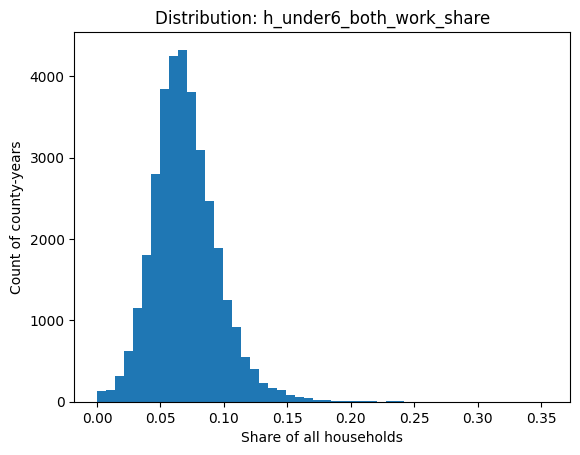

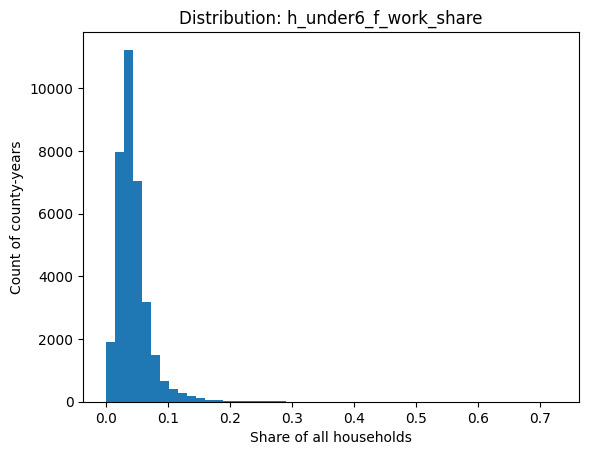

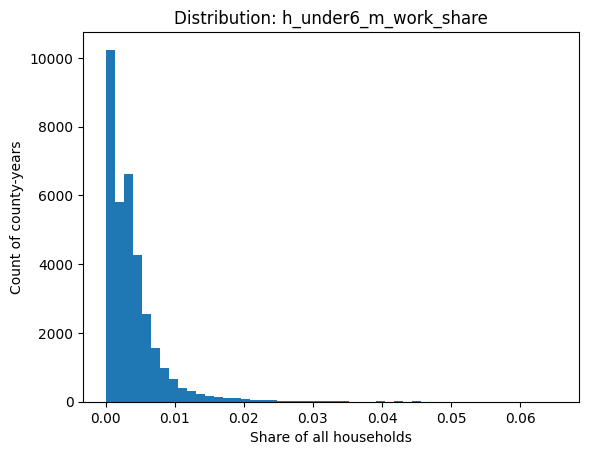

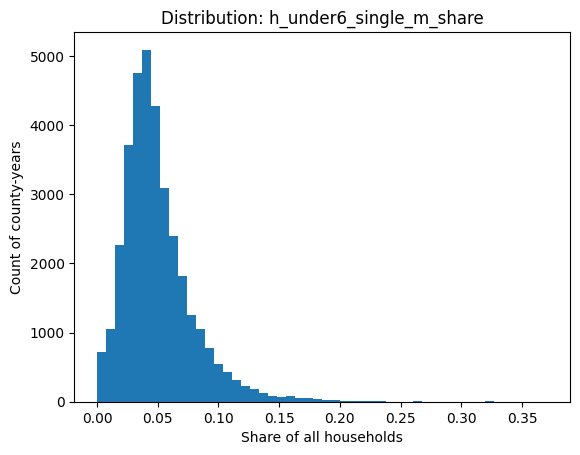

In [ ]:
# Distributions of shares (under 6)
for col in [c + "_share" for c in under6_cols]:
    s = df_hh[col].dropna()
    plt.figure()
    plt.hist(s, bins=50)
    plt.title(f"Distribution: {col}")
    plt.xlabel("Share of all households")
    plt.ylabel("Count of county-years")
    plt.show()

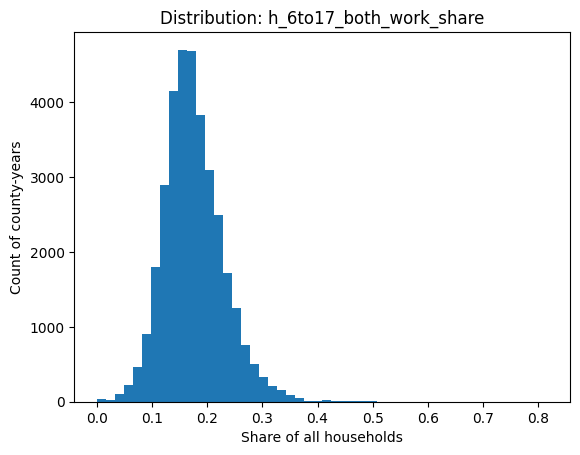

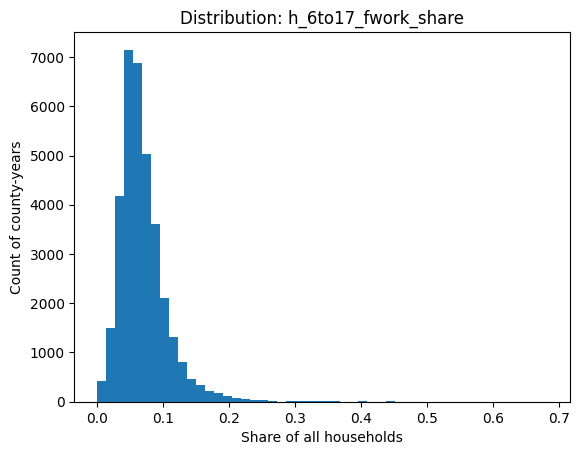

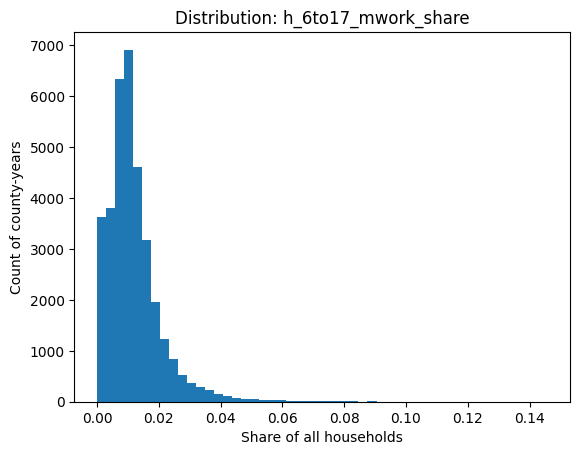

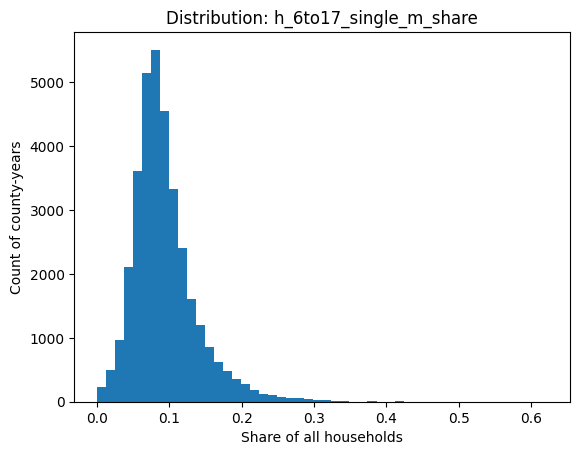

In [ ]:
# Distributions of shares (6–17)
for col in [c + "_share" for c in six17_cols]:
    s = df_hh[col].dropna()
    plt.figure()
    plt.hist(s, bins=50)
    plt.title(f"Distribution: {col}")
    plt.xlabel("Share of all households")
    plt.ylabel("Count of county-years")
    plt.show()

**Interpretation**

We translated household counts into shares of the total population and observed notable variations in family and work structures across counties. For households with children under six, the median share is 6.9% for those with "both parents working" and 4.3% for “single mother” households. "Father-only working" households have a median share of 3.8%, but they exhibit a very long right tail, with a maximum of 72.7%, highlighting extreme variations across county-years. Overall, these distributions and outliers indicate that family composition varies significantly across counties and should be considered a crucial factor when categorizing county types and assessing childcare pressure.

# EDA Insight 4: Burden shows affordability stress and extreme outliers

In [ ]:
df_burden["infant_center_burden"] = (df_burden["mc_infant"] * 52) / df_burden["mhi_2018"]
df_burden["preschool_center_burden"] = (df_burden["mc_preschool"] * 52) / df_burden["mhi_2018"]

df_burden[["infant_center_burden","preschool_center_burden"]].describe()

,infant_center_burden,preschool_center_burden
count,23593.000000,23593.000000
mean,0.151830,0.127876
std,0.043230,0.031951
min,0.032709,0.025407
25%,0.122511,0.105892
50%,0.146516,0.124491
75%,0.173247,0.145850
max,0.543006,0.386522


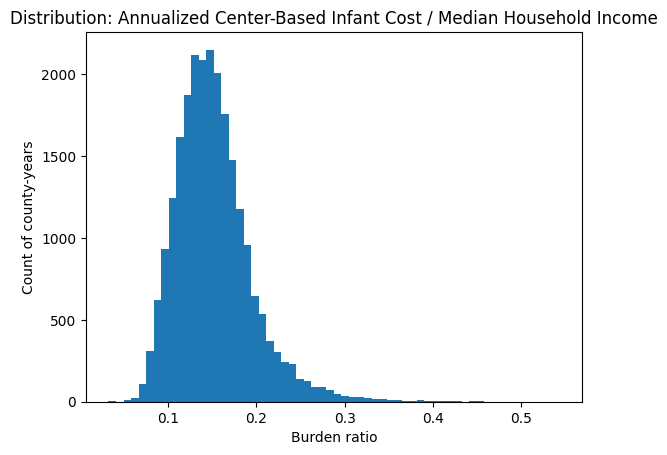

In [ ]:
# Histogram of burden
plt.figure()
plt.hist(df_burden["infant_center_burden"].dropna(), bins=60)
plt.title("Distribution: Annualized Center-Based Infant Cost / Median Household Income")
plt.xlabel("Burden ratio")
plt.ylabel("Count of county-years")
plt.show()

In [ ]:
# Top burden county-years (potential anomalies)
burden_view = df_burden[
    ["county_name","state_abbreviation","study_year","mc_infant","mhi_2018","infant_center_burden"]
].dropna().sort_values("infant_center_burden", ascending=False)

burden_view.head(20)

,county_name,state_abbreviation,study_year,mc_infant,mhi_2018,infant_center_burden
20139,Bronx County,NY,2018,397.70,38085.00,0.543006
32901,Whitman County,WA,2014,369.69,37712.68,0.509746
32593,Ferry County,WA,2014,369.69,39794.52,0.483079
32758,Pacific County,WA,2014,369.69,41783.08,0.460088
32747,Okanogan County,WA,2014,369.69,42044.90,0.457223
32769,Pend Oreille County,WA,2014,369.69,42474.20,0.452601
32759,Pacific County,WA,2015,339.29,39945.04,0.441684
32560,Columbia County,WA,2014,369.69,43535.26,0.441570
32902,Whitman County,WA,2015,322.96,38828.86,0.432511
32846,Stevens County,WA,2014,369.69,44637.66,0.430665


**Interpretation**

We developed a burden metric by annualizing weekly center-based infant childcare prices and dividing by median household income. On average, counties spend about 14.7% of their income on childcare, with an interquartile range of 12.3% to 17.3%. However, some counties report expenditures exceeding 40% to 50%, indicating extreme financial stress.

Notably, in 2018, Bronx County, NY, had a burden of 54.3%, and several Washington State counties (Whitman, Ferry, Pacific, Okanogan, and Pend Oreille) experienced burdens of 44% to 51% from 2014-2015. This suggests that high childcare prices and low incomes in certain areas lead to significant affordability issues.

Ultimately, our analysis shows that focusing only on childcare prices doesn't fully capture affordability. The burden metric helps identify "high-stress" counties where childcare costs are overwhelming for families.

# EDA Insight 5: Occupation mix helps explain where burden, not just price, is high


In [ ]:
occ_cols = ["emp_m", "emp_service", "emp_sales", "emp_n", "emp_p"]

# Quick correlation with burden
occ_corr_cols = occ_cols + ["infant_center_burden", "mc_infant", "mhi_2018", "pr_p"]
df_burden[occ_corr_cols].corr(numeric_only=True).round(2)

,emp_m,emp_service,emp_sales,emp_n,emp_p,infant_center_burden,mc_infant,mhi_2018,pr_p
emp_m,1.00,-0.28,-0.01,-0.42,-0.64,-0.01,0.45,0.62,-0.40
emp_service,-0.28,1.00,-0.05,-0.09,-0.22,0.33,0.00,-0.35,0.37
emp_sales,-0.01,-0.05,1.00,-0.41,-0.23,0.02,0.15,0.18,-0.10
emp_n,-0.42,-0.09,-0.41,1.00,0.02,-0.18,-0.35,-0.27,0.11
emp_p,-0.64,-0.22,-0.23,0.02,1.00,-0.07,-0.33,-0.38,0.19
infant_center_burden,-0.01,0.33,0.02,-0.18,-0.07,1.00,0.67,-0.16,0.27
mc_infant,0.45,0.00,0.15,-0.35,-0.33,0.67,1.00,0.60,-0.35
mhi_2018,0.62,-0.35,0.18,-0.27,-0.38,-0.16,0.60,1.00,-0.75
pr_p,-0.40,0.37,-0.10,0.11,0.19,0.27,-0.35,-0.75,1.00


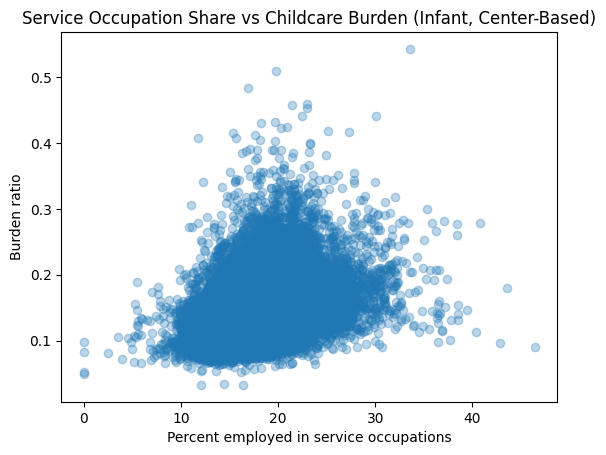

In [ ]:
# Simple scatter: service share vs burden (example)
x = df_burden["emp_service"]
y = df_burden["infant_center_burden"]
mask = x.notna() & y.notna()

plt.figure()
plt.scatter(x[mask], y[mask], alpha=0.3)
plt.title("Service Occupation Share vs Childcare Burden (Infant, Center-Based)")
plt.xlabel("Percent employed in service occupations")
plt.ylabel("Burden ratio")
plt.show()

**Interpretation**

We analyzed the relationship between occupation composition and both raw childcare prices and affordability burdens. Our findings show a positive correlation between center-based infant prices and the share of management/professional employment (emp_m ≈ 0.45) and income levels (mhi_2018 ≈ 0.60), indicating that higher prices are common in wealthier, professional-heavy counties.

In contrast, the burden measure is most strongly associated with the service employment share (emp_service ≈ 0.33) and poverty (pr_p ≈ 0.27), while showing a slight negative correlation with income (≈ -0.16).

This distinction emphasizes that some counties have high childcare costs due to wealth, while others experience affordability challenges due to their labor market structure. Analyzing occupation mix is thus effective for identifying counties where childcare is financially stressful, beyond just those with high costs.


# EDA Insight 6: Demographics relate more to income and price context than to burden

In [ ]:
demo_cols = ["one_race_w","one_race_b","one_race_a","one_race_i","one_race_h","one_race_other","two_races","hispanic"]

demo_corr_cols = demo_cols + ["infant_center_burden", "mc_infant", "mhi_2018", "pr_p"]
df_burden[demo_corr_cols].corr(numeric_only=True).round(2)

,one_race_w,one_race_b,one_race_a,one_race_i,one_race_h,one_race_other,two_races,hispanic,infant_center_burden,mc_infant,mhi_2018,pr_p
one_race_w,1.00,-0.82,-0.25,-0.35,-0.11,-0.23,-0.21,-0.10,-0.11,-0.01,0.12,-0.46
one_race_b,-0.82,1.00,0.02,-0.10,-0.05,-0.05,-0.11,-0.10,0.02,-0.15,-0.22,0.41
one_race_a,-0.25,0.02,1.00,-0.05,0.39,0.23,0.27,0.17,0.20,0.55,0.49,-0.17
one_race_i,-0.35,-0.10,-0.05,1.00,0.04,-0.03,0.26,-0.04,0.03,-0.05,-0.10,0.27
one_race_h,-0.11,-0.05,0.39,0.04,1.00,0.09,0.29,0.07,0.10,0.17,0.11,-0.04
one_race_other,-0.23,-0.05,0.23,-0.03,0.09,1.00,0.14,0.71,0.11,0.19,0.13,0.03
two_races,-0.21,-0.11,0.27,0.26,0.29,0.14,1.00,0.10,0.19,0.24,0.11,-0.00
hispanic,-0.10,-0.10,0.17,-0.04,0.07,0.71,0.10,1.00,0.07,0.10,0.07,0.10
infant_center_burden,-0.11,0.02,0.20,0.03,0.10,0.11,0.19,0.07,1.00,0.67,-0.16,0.27
mc_infant,-0.01,-0.15,0.55,-0.05,0.17,0.19,0.24,0.10,0.67,1.00,0.60,-0.35


**Interpretation**

We studied how the racial and ethnic makeup of a community relates to childcare prices, income, poverty, and affordability issues. Our findings show that certain demographic groups have stronger links to income and childcare prices than to affordability problems. For example, the percentage of Asian residents (one_race_a) is highly linked to both childcare prices (0.55) and income (0.49). Meanwhile, the percentage of Black residents (one_race_b) is more closely tied to poverty (0.41) and negatively related to income (-0.22).

In general, the links between demographic shares and affordability issues are small, mostly between 0.02 and 0.20.

This suggests that while demographic makeup can help explain the economic context of childcare prices, it does not directly show where childcare is most unaffordable. So, demographics are better for profiling and understanding different county types, rather than serving as key predictors of affordability stress.